In [1]:
import tensorflow as tf
import dataloader
import cnn_model
import focal_loss
import matplotlib.pyplot as plt
import pandas
import cleanlab
import sklearn.metrics
import subprocess
import numpy as np
import pickle
import glob
import os
import gc

2026-01-24 12:34:23.926632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Config variables

In [2]:
k = 6
n_epochs = 1000
initial_learning_rate = 1e-3

# features = ["optical"]
# features = ["optical", "elevation", "slope"]
# features = ["optical", "elevation", "slope", "shadow_mask", "hillshade"]
features = ["optical", "elevation", "slope", "shadow_mask", "hillshade", "proximity"]
input_features = 0
for feature in features:
    input_features += len(dataloader.ftr_map[feature])

# Curating data with confident learning

In [3]:
for test_fold in range(k):        
    val_fold = (test_fold - 1) % k
    train_folds = [_ for _ in range(k) if _ not in {val_fold, test_fold}]
    
    train_set = dataloader.get_folds_dataset(
        folder="../dataset/patches", 
        folds=train_folds,
        features=features,
        use_augmentation=True, 
        use_label_smoothing=True, 
        shuffle=True,
        use_sample_weights=True,
    )
    val_set = dataloader.get_folds_dataset(
        folder="../dataset/patches", 
        folds=[val_fold],
        features=features,
    )
    
    model_name = f"{test_fold}_cnn_beforeconfidentlearning"
    model = cnn_model.build_cnn_model(input_features=input_features, name=model_name)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=tf.keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=n_epochs * train_set.cardinality(),
            ),
        ),
        # loss=tf.keras.losses.CategoricalFocalCrossentropy(),
        loss=focal_loss.FocalLoss(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.MeanIoU(
                num_classes=len(dataloader.cls_map.keys()),
                sparse_y_true=False,
                sparse_y_pred=False,
                name="miou"
            ),
        ],
        weighted_metrics=[],
    )
    
    train_callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            f"weights/{model_name}_weights.h5",
            monitor=f"val_miou",
            mode="max",
            save_best_only=True,
            save_weights_only=True,
        ),
        tf.keras.callbacks.CSVLogger(f"logs/{model_name}_log.csv"),
    ]
    
    model.fit(
        train_set,
        epochs=n_epochs,
        validation_data=val_set,
        callbacks=train_callbacks,
        verbose=2
    )

    del train_set
    del val_set
    del model
    gc.collect()

Reading data...: 100%|███████████████████████████████████████████████████████████████████████| 70576/70576 [08:00<00:00, 146.83it/s]
2026-01-23 09:50:50.410647: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-23 09:50:50.433291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-23 09:50:50.433610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-23 09:50:50.434312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to

Epoch 1/1000


2026-01-23 10:01:42.063741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2026-01-23 10:01:43.560767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2026-01-23 10:01:43.587287: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fd464e618e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-23 10:01:43.587346: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTXA6000-48Q, Compute Capability 8.6
2026-01-23 10:01:43.592016: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-23 10:01:43.685637: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the 

138/138 - 21s - loss: 839.9329 - categorical_accuracy: 0.2546 - miou: 0.1118 - val_loss: 0.9871 - val_categorical_accuracy: 0.4812 - val_miou: 0.2658 - 21s/epoch - 151ms/step
Epoch 2/1000
138/138 - 13s - loss: 580.6272 - categorical_accuracy: 0.3327 - miou: 0.1553 - val_loss: 1.0660 - val_categorical_accuracy: 0.4016 - val_miou: 0.2103 - 13s/epoch - 91ms/step
Epoch 3/1000
138/138 - 11s - loss: 490.7863 - categorical_accuracy: 0.3812 - miou: 0.1832 - val_loss: 0.8044 - val_categorical_accuracy: 0.5479 - val_miou: 0.2986 - 11s/epoch - 82ms/step
Epoch 4/1000
138/138 - 10s - loss: 429.8423 - categorical_accuracy: 0.4363 - miou: 0.2170 - val_loss: 0.5956 - val_categorical_accuracy: 0.5494 - val_miou: 0.2933 - 10s/epoch - 76ms/step
Epoch 5/1000
138/138 - 11s - loss: 399.1005 - categorical_accuracy: 0.4696 - miou: 0.2401 - val_loss: 1.0656 - val_categorical_accuracy: 0.3452 - val_miou: 0.1764 - 11s/epoch - 77ms/step
Epoch 6/1000
138/138 - 10s - loss: 361.6743 - categorical_accuracy: 0.5120 - 

Reading data...:  23%|███████████████▉                                                      | 26948/118155 [04:01<13:05, 116.17it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 61/1000
231/231 - 13s - loss: 209.0936 - categorical_accuracy: 0.8607 - miou: 0.6405 - val_loss: 0.3478 - val_categorical_accuracy: 0.7436 - val_miou: 0.5493 - 13s/epoch - 57ms/step
Epoch 62/1000
231/231 - 13s - loss: 210.6806 - categorical_accuracy: 0.8577 - miou: 0.6340 - val_loss: 0.4206 - val_categorical_accuracy: 0.7136 - val_miou: 0.5176 - 13s/epoch - 57ms/step
Epoch 63/1000
231/231 - 13s - loss: 211.1166 - categorical_accuracy: 0.8540 - miou: 0.6279 - val_loss: 0.3139 - val_categorical_accuracy: 0.7766 - val_miou: 0.5602 - 13s/epoch - 57ms/step
Epoch 64/1000
231/231 - 14s - loss: 210.2639 - categorical_accuracy: 0.8594 - miou: 0.6402 - val_loss: 0.3161 - val_categorical_accuracy: 0.7470 - val_miou: 0.5358 - 14s/epoch - 59ms/step
Epoch 65/1000
231/231 - 13s - loss: 208.3279 - categorical_accuracy: 0.8610 - miou: 0.6424 - val_loss: 0.3956 - val_categorical_accuracy: 0.7105 - val_miou: 0.5278 - 13s/epoch - 57ms/step
Epoch 66/1000
231/231 - 13s - loss: 214.0798 - categorical_a

Reading data...:  25%|█████████████████▌                                                     | 24224/97896 [03:43<11:12, 109.52it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



192/192 - 12s - loss: 174.3596 - categorical_accuracy: 0.9645 - miou: 0.9009 - val_loss: 0.3029 - val_categorical_accuracy: 0.8722 - val_miou: 0.6175 - 12s/epoch - 62ms/step
Epoch 828/1000
192/192 - 12s - loss: 173.4257 - categorical_accuracy: 0.9659 - miou: 0.9039 - val_loss: 0.2947 - val_categorical_accuracy: 0.8735 - val_miou: 0.6260 - 12s/epoch - 62ms/step
Epoch 829/1000
192/192 - 12s - loss: 173.8738 - categorical_accuracy: 0.9656 - miou: 0.9099 - val_loss: 0.2989 - val_categorical_accuracy: 0.8747 - val_miou: 0.6260 - 12s/epoch - 62ms/step
Epoch 830/1000
192/192 - 12s - loss: 173.5828 - categorical_accuracy: 0.9666 - miou: 0.9085 - val_loss: 0.3055 - val_categorical_accuracy: 0.8717 - val_miou: 0.6232 - 12s/epoch - 63ms/step
Epoch 831/1000
192/192 - 12s - loss: 173.4145 - categorical_accuracy: 0.9655 - miou: 0.9075 - val_loss: 0.3119 - val_categorical_accuracy: 0.8687 - val_miou: 0.6127 - 12s/epoch - 63ms/step
Epoch 832/1000
192/192 - 12s - loss: 172.6991 - categorical_accuracy: 

Reading data...:  33%|███████████████████████                                                | 30196/92886 [04:37<09:33, 109.37it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 237/1000
182/182 - 12s - loss: 194.1746 - categorical_accuracy: 0.9205 - miou: 0.7665 - val_loss: 0.4871 - val_categorical_accuracy: 0.7029 - val_miou: 0.4584 - 12s/epoch - 68ms/step
Epoch 238/1000
182/182 - 12s - loss: 194.9923 - categorical_accuracy: 0.9199 - miou: 0.7664 - val_loss: 0.4538 - val_categorical_accuracy: 0.7530 - val_miou: 0.5496 - 12s/epoch - 68ms/step
Epoch 239/1000
182/182 - 12s - loss: 195.0209 - categorical_accuracy: 0.9183 - miou: 0.7484 - val_loss: 0.4153 - val_categorical_accuracy: 0.7580 - val_miou: 0.4988 - 12s/epoch - 68ms/step
Epoch 240/1000
182/182 - 12s - loss: 195.1734 - categorical_accuracy: 0.9212 - miou: 0.7696 - val_loss: 0.4051 - val_categorical_accuracy: 0.7507 - val_miou: 0.5526 - 12s/epoch - 67ms/step
Epoch 241/1000
182/182 - 12s - loss: 193.2868 - categorical_accuracy: 0.9215 - miou: 0.7648 - val_loss: 0.5593 - val_categorical_accuracy: 0.6912 - val_miou: 0.4472 - 12s/epoch - 67ms/step
Epoch 242/1000
182/182 - 12s - loss: 195.2368 - categor

Reading data...:  15%|██████████▋                                                           | 16198/106712 [02:32<14:15, 105.81it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Reading data...: 100%|███████████████████████████████████████████████████████████████████████| 14093/14093 [02:16<00:00, 103.05it/s]


Epoch 1/1000
209/209 - 21s - loss: 943.0605 - categorical_accuracy: 0.2756 - miou: 0.1302 - val_loss: 0.8581 - val_categorical_accuracy: 0.5111 - val_miou: 0.2788 - 21s/epoch - 99ms/step
Epoch 2/1000
209/209 - 12s - loss: 607.2911 - categorical_accuracy: 0.3472 - miou: 0.1811 - val_loss: 0.5354 - val_categorical_accuracy: 0.6081 - val_miou: 0.3430 - 12s/epoch - 58ms/step
Epoch 3/1000
209/209 - 12s - loss: 501.1637 - categorical_accuracy: 0.3969 - miou: 0.2172 - val_loss: 0.5195 - val_categorical_accuracy: 0.6338 - val_miou: 0.3751 - 12s/epoch - 58ms/step
Epoch 4/1000
209/209 - 12s - loss: 444.9153 - categorical_accuracy: 0.4391 - miou: 0.2449 - val_loss: 0.6737 - val_categorical_accuracy: 0.5523 - val_miou: 0.3097 - 12s/epoch - 59ms/step
Epoch 5/1000
209/209 - 13s - loss: 431.7733 - categorical_accuracy: 0.4594 - miou: 0.2599 - val_loss: 0.4929 - val_categorical_accuracy: 0.6742 - val_miou: 0.4184 - 13s/epoch - 60ms/step
Epoch 6/1000
209/209 - 12s - loss: 399.7515 - categorical_accurac

Reading data...:   3%|██▏                                                                     | 1901/64143 [00:18<09:46, 106.14it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



126/126 - 8s - loss: 163.2083 - categorical_accuracy: 0.9599 - miou: 0.8486 - val_loss: 0.3926 - val_categorical_accuracy: 0.8069 - val_miou: 0.4732 - 8s/epoch - 65ms/step
Epoch 686/1000
126/126 - 8s - loss: 162.9179 - categorical_accuracy: 0.9596 - miou: 0.8478 - val_loss: 0.4005 - val_categorical_accuracy: 0.8013 - val_miou: 0.4715 - 8s/epoch - 66ms/step
Epoch 687/1000
126/126 - 8s - loss: 163.1165 - categorical_accuracy: 0.9601 - miou: 0.8496 - val_loss: 0.4051 - val_categorical_accuracy: 0.8024 - val_miou: 0.5329 - 8s/epoch - 64ms/step
Epoch 688/1000
126/126 - 8s - loss: 164.3576 - categorical_accuracy: 0.9599 - miou: 0.8448 - val_loss: 0.3985 - val_categorical_accuracy: 0.8058 - val_miou: 0.5379 - 8s/epoch - 64ms/step
Epoch 689/1000
126/126 - 8s - loss: 164.3272 - categorical_accuracy: 0.9601 - miou: 0.8449 - val_loss: 0.4021 - val_categorical_accuracy: 0.8037 - val_miou: 0.5357 - 8s/epoch - 64ms/step
Epoch 690/1000
126/126 - 8s - loss: 163.7802 - categorical_accuracy: 0.9595 - mi

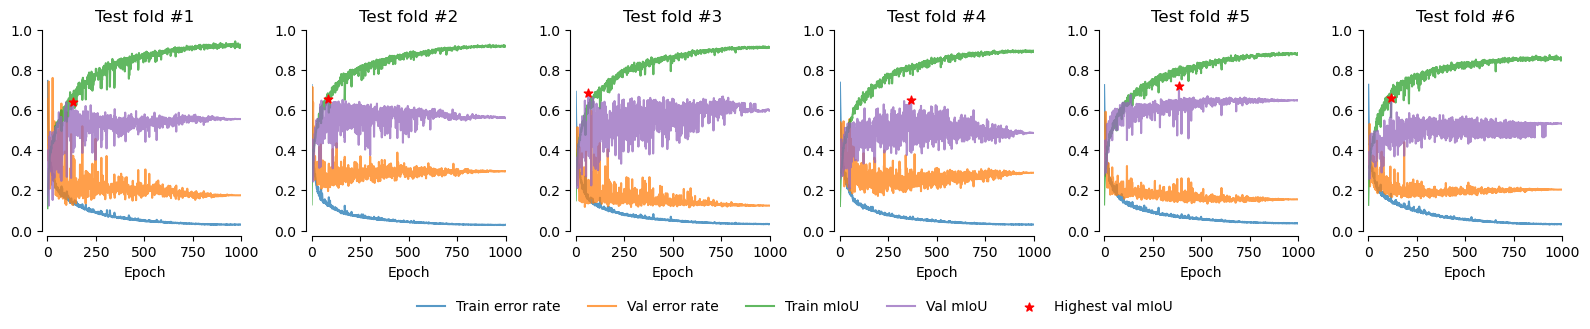

In [4]:
fig, axs = plt.subplots(ncols=k, figsize=(16, 3))
alpha = 0.75

for test_fold in range(k):
    log = pandas.read_csv(f"logs/{test_fold}_cnn_beforeconfidentlearning_log.csv")
    
    ax = axs[test_fold]
    ax.set_title(f"Test fold #{test_fold + 1}")
    ax.plot(log.epoch, 1 - log.categorical_accuracy, label="Train error rate", color="C0", alpha=alpha)
    ax.plot(log.epoch, 1 - log.val_categorical_accuracy, label="Val error rate", color="C1", alpha=alpha)
    ax.plot(log.epoch, log.miou, label="Train mIoU", color="C2", alpha=alpha)
    ax.plot(log.epoch, log.val_miou, label="Val mIoU", color="C4", alpha=alpha)
    ax.scatter(
        log.epoch[log.val_miou.argmax()], log.val_miou.max(), 
        label="Highest val mIoU", marker="*", s=40, color="red", zorder=3
    )
    ax.set_xlim(0, n_epochs)
    ax.set_ylim(0.0, 1.00)
    ax.set_xlabel("Epoch")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 4))
    ax.spines["bottom"].set_position(("outward", 4))
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncols=5, loc="upper center", frameon=False, bbox_to_anchor=(0.5, 0.025))    

plt.tight_layout()
plt.show()

In [5]:
all_preds = []
all_paths = []

for test_fold in range(k):
    test_set, paths = dataloader.get_folds_dataset(
        folder="../dataset/patches", 
        folds=[test_fold],
        features=features,
        return_paths=True,
    )
    
    model_name = f"{test_fold}_cnn_beforeconfidentlearning"
    model = cnn_model.build_cnn_model(input_features=input_features, name=model_name)
    model.load_weights(f"weights/{model_name}_weights.h5")
    
    # model.compile(
    #     loss=focal_loss.FocalLoss(),
    #     metrics=[
    #         tf.keras.metrics.CategoricalAccuracy(),
    #         tf.keras.metrics.MeanIoU(
    #             num_classes=len(dataloader.cls_map.keys()),
    #             sparse_y_true=False,
    #             sparse_y_pred=False,
    #             name="miou"
    #         ),
    #     ],
    #     weighted_metrics=[],
    # )
    
    preds = model.predict(test_set)
    all_preds.extend(preds)
    all_paths.extend(paths)

    del test_set
    del model
    gc.collect()

Reading data...: 100%|███████████████████████████████████████████████████████████████████████| 10354/10354 [01:35<00:00, 108.87it/s]


21/21 [==============================] - 1s 24ms/step


Reading data...: 100%|█████████████████████████████████████████████████████████████████████████| 9083/9083 [01:24<00:00, 107.09it/s]


18/18 [==============================] - 1s 23ms/step


Reading data...: 100%|███████████████████████████████████████████████████████████████████████| 30613/30613 [04:51<00:00, 104.91it/s]


60/60 [==============================] - 3s 22ms/step


Reading data...: 100%|███████████████████████████████████████████████████████████████████████| 14093/14093 [02:18<00:00, 101.47it/s]


28/28 [==============================] - 1s 22ms/step


Reading data...: 100%|███████████████████████████████████████████████████████████████████████| 16787/16787 [02:46<00:00, 100.62it/s]


33/33 [==============================] - 2s 21ms/step


Reading data...: 100%|███████████████████████████████████████████████████████████████████████| 56662/56662 [08:26<00:00, 111.78it/s]


111/111 [==============================] - 5s 25ms/step


In [6]:
def path_to_cls(path):
    filename = path.split(os.sep)[-1]
    filename = filename.split('.')[0]
    parts = filename.split('_')
    cls = parts[-1]  
    cls = dataloader.cls_map[cls]
    return np.argmax(cls)


all_labels = np.array([path_to_cls(_) for _ in all_paths])

In [7]:
pred_probs = np.array(all_preds)

label_issues = cleanlab.filter.find_label_issues(
    labels=all_labels,
    pred_probs=pred_probs,
    return_indices_ranked_by="self_confidence",
    filter_by="confident_learning", 
    n_jobs=16,
)

In [8]:
# we assume that labels for shadow, cloud and water are correct
label_issues = np.array([_ for _ in label_issues if all_labels[_] in {0, 1, 2, 3, 5}])

In [9]:
all_paths = np.array(all_paths)
to_exclude = all_paths[label_issues]
to_exclude = set(to_exclude)

In [10]:
with open("to_exclude.pickle", "wb") as to_exclude_dst:
    pickle.dump(to_exclude, to_exclude_dst)

In [11]:
___issues_classes = all_labels[label_issues]

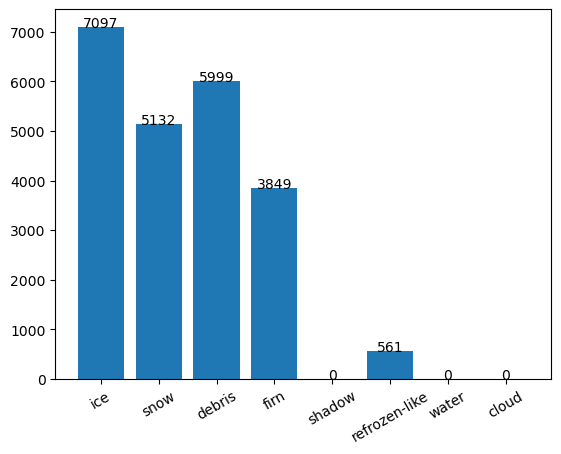

In [12]:
xs = [_ for _ in range(len(dataloader.cls_map.keys()))]
ys = [np.sum(___issues_classes == _) for _ in xs]
for i in xs:
    plt.text(i, ys[i], ys[i], ha="center")
plt.xticks(xs, dataloader.cls_map.keys(), rotation=30)
plt.bar(xs, ys)
plt.show()

# Training on curated data

In [3]:
with open("to_exclude.pickle", "rb") as to_exclude_src:
    to_exclude = pickle.load(to_exclude_src)

In [4]:
for test_fold in range(k):
    val_fold = (test_fold - 1) % k
    train_folds = [_ for _ in range(k) if _ not in {val_fold, test_fold}]
    
    train_set = dataloader.get_folds_dataset(
        folder="../dataset/patches", 
        folds=train_folds,
        features=features,
        use_augmentation=True, 
        use_label_smoothing=True, 
        shuffle=True,
        use_sample_weights=True,
        exclude=to_exclude,
    )
    val_set = dataloader.get_folds_dataset(
        folder="../dataset/patches", 
        folds=[val_fold],
        features=features,
        exclude=to_exclude,
    )
    
    model_name = f"{test_fold}_cnn_afterconfidentlearning"
    model = cnn_model.build_cnn_model(input_features=input_features, name=model_name)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=tf.keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=n_epochs * train_set.cardinality(),
            ),
        ),
        # loss=tf.keras.losses.CategoricalFocalCrossentropy(),
        loss=focal_loss.FocalLoss(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.MeanIoU(
                num_classes=len(dataloader.cls_map.keys()),
                sparse_y_true=False,
                sparse_y_pred=False,
                name="miou"
            ),
        ],
        weighted_metrics=[],
    )
    
    train_callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            f"weights/{model_name}_weights.h5",
            monitor=f"val_miou",
            mode="max",
            save_best_only=True,
            save_weights_only=True,
        ),
        tf.keras.callbacks.CSVLogger(f"logs/{model_name}_log.csv"),
    ]
    
    model.fit(
        train_set,
        epochs=n_epochs,
        validation_data=val_set,
        callbacks=train_callbacks,
        verbose=2
    )

    del train_set
    del val_set
    del model
    gc.collect()

Reading data...:  79%|████████████████████████████████████████████████████████▎              | 47776/60214 [05:27<01:25, 145.41it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Reading data...:  65%|█████████████████████████████████████████████▉                         | 63845/98810 [09:35<05:00, 116.44it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Reading data...:  78%|███████████████████████████████████████████████████████▌               | 63977

Epoch 1/1000
105/105 - 14s - loss: 863.6352 - categorical_accuracy: 0.2625 - miou: 0.1251 - val_loss: 0.8908 - val_categorical_accuracy: 0.4999 - val_miou: 0.2185 - 14s/epoch - 130ms/step
Epoch 2/1000
105/105 - 7s - loss: 572.8455 - categorical_accuracy: 0.3813 - miou: 0.1866 - val_loss: 0.8363 - val_categorical_accuracy: 0.5417 - val_miou: 0.2565 - 7s/epoch - 66ms/step
Epoch 3/1000
105/105 - 7s - loss: 488.1480 - categorical_accuracy: 0.4403 - miou: 0.2243 - val_loss: 0.6078 - val_categorical_accuracy: 0.6353 - val_miou: 0.3194 - 7s/epoch - 66ms/step
Epoch 4/1000
105/105 - 7s - loss: 434.6011 - categorical_accuracy: 0.5008 - miou: 0.2572 - val_loss: 0.3520 - val_categorical_accuracy: 0.7579 - val_miou: 0.3880 - 7s/epoch - 68ms/step
Epoch 5/1000
105/105 - 7s - loss: 397.4251 - categorical_accuracy: 0.5522 - miou: 0.2945 - val_loss: 0.3712 - val_categorical_accuracy: 0.7523 - val_miou: 0.4370 - 7s/epoch - 68ms/step
Epoch 6/1000
105/105 - 7s - loss: 368.6638 - categorical_accuracy: 0.595

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



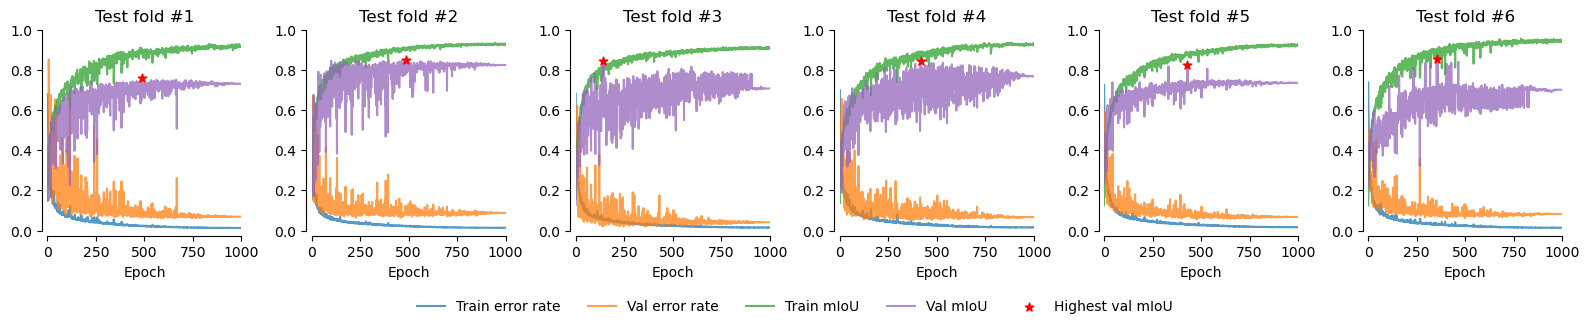

In [5]:
fig, axs = plt.subplots(ncols=k, figsize=(16, 3))
alpha = 0.75

for test_fold in range(k):
    log = pandas.read_csv(f"logs/{test_fold}_cnn_afterconfidentlearning_log.csv")
    
    ax = axs[test_fold]
    ax.set_title(f"Test fold #{test_fold + 1}")
    ax.plot(log.epoch, 1 - log.categorical_accuracy, label="Train error rate", color="C0", alpha=alpha)
    ax.plot(log.epoch, 1 - log.val_categorical_accuracy, label="Val error rate", color="C1", alpha=alpha)
    ax.plot(log.epoch, log.miou, label="Train mIoU", color="C2", alpha=alpha)
    ax.plot(log.epoch, log.val_miou, label="Val mIoU", color="C4", alpha=alpha)
    ax.scatter(
        log.epoch[log.val_miou.argmax()], log.val_miou.max(), 
        label="Highest val mIoU", marker="*", s=40, color="red", zorder=3
    )
    ax.set_xlim(0, n_epochs)
    ax.set_ylim(0.0, 1.00)
    ax.set_xlabel("Epoch")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 4))
    ax.spines["bottom"].set_position(("outward", 4))
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncols=5, loc="upper center", frameon=False, bbox_to_anchor=(0.5, 0.025))    

plt.tight_layout()
plt.show()

# Assessing performance

In [6]:
all_preds = []
all_paths = []

for test_fold in range(k):
    test_set, paths = dataloader.get_folds_dataset(
        folder="../dataset/patches", 
        folds=[test_fold],
        features=features,
        return_paths=True,
        exclude=to_exclude,
    )
    
    model_name = f"{test_fold}_cnn_afterconfidentlearning"
    model = cnn_model.build_cnn_model(input_features=input_features, name=model_name)
    model.load_weights(f"weights/{model_name}_weights.h5")
    
    model.compile(
        loss=focal_loss.FocalLoss(),
        # loss=tf.keras.losses.CategoricalFocalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.MeanIoU(
                num_classes=len(dataloader.cls_map.keys()),
                sparse_y_true=False,
                sparse_y_pred=False,
                name="miou"
            ),
        ],
        weighted_metrics=[],
    )
    
    preds = model.predict(test_set)
    all_preds.extend(preds)
    all_paths.extend(paths)

    model.evaluate(test_set)

    del test_set
    del model
    gc.collect()

Reading data...: 100%|██████████████████████████████████████████████████████████████████████████| 8151/8151 [01:24<00:00, 97.00it/s]


16/16 [==============================] - 1s 19ms/step - loss: 0.1845 - categorical_accuracy: 0.9138 - miou: 0.7896


Reading data...: 100%|█████████████████████████████████████████████████████████████████████████| 7993/7993 [01:18<00:00, 101.55it/s]


16/16 [==============================] - 1s 18ms/step - loss: 0.1137 - categorical_accuracy: 0.9523 - miou: 0.7935


Reading data...: 100%|███████████████████████████████████████████████████████████████████████| 25256/25256 [04:07<00:00, 102.15it/s]


50/50 [==============================] - 1s 18ms/step - loss: 0.2634 - categorical_accuracy: 0.8483 - miou: 0.7080


Reading data...: 100%|███████████████████████████████████████████████████████████████████████| 12291/12291 [02:02<00:00, 100.54it/s]


25/25 [==============================] - 1s 18ms/step - loss: 0.2136 - categorical_accuracy: 0.9013 - miou: 0.6923


Reading data...: 100%|████████████████████████████████████████████████████████████████████████| 14674/14674 [02:26<00:00, 99.87it/s]


29/29 [==============================] - 1s 19ms/step - loss: 0.1705 - categorical_accuracy: 0.9164 - miou: 0.7141


Reading data...: 100%|███████████████████████████████████████████████████████████████████████| 46589/46589 [07:42<00:00, 100.68it/s]


91/91 [==============================] - 2s 19ms/step - loss: 0.1922 - categorical_accuracy: 0.9112 - miou: 0.7089


In [7]:
def path_to_cls(path):
    filename = path.split(os.sep)[-1]
    filename = filename.split('.')[0]
    parts = filename.split('_')
    cls = parts[-1]  
    cls = dataloader.cls_map[cls]
    return np.argmax(cls)


all_labels = np.array([path_to_cls(_) for _ in all_paths])

In [8]:
all_preds_int = np.argmax(all_preds, axis=-1)

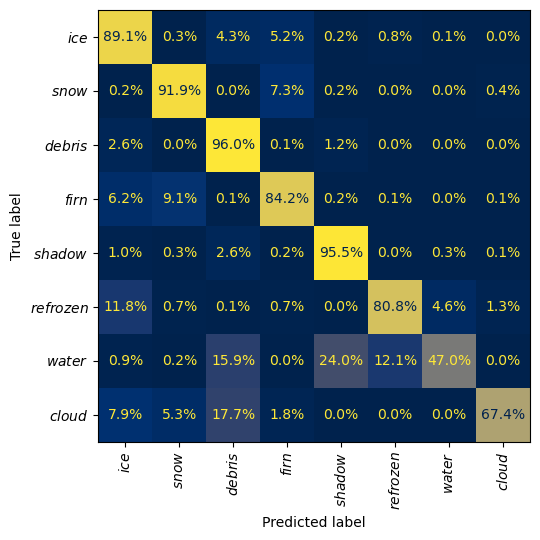

In [9]:
confusion_matrix = sklearn.metrics.confusion_matrix(all_labels, all_preds_int)
confusion_matrix_norm = sklearn.metrics.confusion_matrix(all_labels, all_preds_int, normalize="true")

_, ax = plt.subplots(figsize=(5.5, 5.5))
display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix_norm, display_labels=dataloader.cls_map.keys())
display.plot(ax=ax, xticks_rotation="vertical", cmap="cividis", values_format=".1%", colorbar=False)
ticks = ["$\mathit{ice}$", "$\mathit{snow}$", "$\mathit{debris}$", "$\mathit{firn}$", "$\mathit{shadow}$", "$\mathit{refrozen}$", "$\mathit{water}$", "$\mathit{cloud}$"]
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
plt.tight_layout()
plt.savefig("../manuscript_assets/confusion_mastrix.pdf", transparent=True, bbox_inches="tight", pad_inches=0.02)
plt.show()

In [10]:
for cls_idx, cls_name in enumerate(dataloader.cls_map.keys()):
    cls_true = (all_labels == cls_idx)
    cls_pred = (all_preds_int == cls_idx)
    
    acc = sklearn.metrics.accuracy_score(cls_true, cls_pred)
    prec = sklearn.metrics.precision_score(cls_true, cls_pred)
    rec = sklearn.metrics.recall_score(cls_true, cls_pred)
    f1 = sklearn.metrics.f1_score(cls_true, cls_pred)
    print(f"{cls_name}:")
    print(f"\t Accuracy={acc:.2%}, \t Precision={prec:.2%}, \t Recall={rec:.2%}, \t F1={f1:.2%}")

ice:
	 Accuracy=94.16%, 	 Precision=95.45%, 	 Recall=89.08%, 	 F1=92.15%
snow:
	 Accuracy=96.76%, 	 Precision=92.75%, 	 Recall=91.95%, 	 F1=92.35%
debris:
	 Accuracy=97.35%, 	 Precision=86.68%, 	 Recall=95.97%, 	 F1=91.09%
firn:
	 Accuracy=94.04%, 	 Precision=77.67%, 	 Recall=84.21%, 	 F1=80.81%
shadow:
	 Accuracy=99.16%, 	 Precision=94.86%, 	 Recall=95.50%, 	 F1=95.18%
refrozen-like:
	 Accuracy=99.30%, 	 Precision=75.93%, 	 Recall=80.80%, 	 F1=78.29%
water:
	 Accuracy=99.56%, 	 Precision=65.24%, 	 Recall=46.99%, 	 F1=54.63%
cloud:
	 Accuracy=99.66%, 	 Precision=69.26%, 	 Recall=67.36%, 	 F1=68.30%
